# Week 6: Optical Flow

**The exercise of this week is about Optical Flow. First load the following libraries that will be necessary.**

In [1]:
!pip3 install --user scipy
!pip3 install --user scikit-image
!pip3 install --user matplotlib


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\LauraZeller\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\LauraZeller\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\LauraZeller\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
from skimage.io import imread
from scipy import signal, ndimage
import numpy as np
import time
import scipy.io as sio
from matplotlib.pyplot import imshow, show, figure
import skimage.transform as tf
import IPython
import flow_vis

**We will compute the optical flow between two images. Load the two images `frame1.png` and `frame2.png`.**

max flow: 4.6157 flow range: u = -4.576 .. 2.575; v = -2.575 .. 2.919



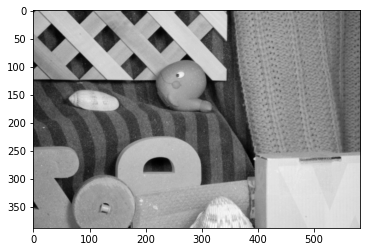

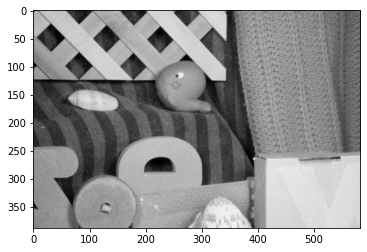

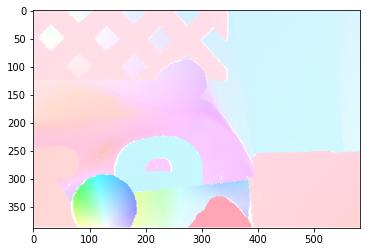

In [3]:
image1 = imread('frame1.png',as_gray=True)
image2 = imread('frame2.png',as_gray=True)
figure()
imshow(image1, cmap='gray')
figure()
imshow(image2, cmap='gray')

flow_gt = sio.loadmat('flow_gt.mat')['groundTruth']
flow_image_gt = flow_vis.flow_to_color(flow_gt)
figure()
imshow(flow_image_gt, cmap='gray')

## Part A: Lukas-Knade Algorithm
We estimate the optical flow $u,v$ by solving the lineary system 
$$I_xu+I_yv+I_t=0$$

The spatial partial $I_x$ and $I_y$ derivatives are computed by convolving the patches with a 1D-kernel $[-1,1]$ and taking the average between the two patches. In order to make the estimates more robust, we furthermore smooth the derivatives with a 1D-kernel $\frac{1}{2}[1,1]$. These steps can be combined in a single convolution. For example the partial
derivative in x-direction between patches $I_1$ and $I_2$ is given by 

$$I_x = (I_1+I_2)*\frac{1}{4}\begin{bmatrix}-1 & 1\\ -1 & 1\end{bmatrix}$$

*technically, we could just use a 1D filter, but by doing this, we'll get a smoother derivation*

where $∗$ denotes the 2D convolution operator. Analogously, the partial temporal derivative is given by 

$$I_t = (I_2-I_1)*\frac{1}{4}\begin{bmatrix}1 & 1\\ 1 & 1\end{bmatrix}.$$

*We apply a 2x2 filter.*

**Complete the missing lines to define the convolution kernels and to compute the partial derivatives. You can use `signal.convolve2d(x, kernel, mode='same')` for convolution.** 


After computing the partial derivatives, we can estimate the optical flow for each patch by solving the following linear system
$ A^{T} Ax=A^{T} b$ with
$$ A = \begin{bmatrix}p_x & p_y\end{bmatrix} \text{and } b = -p_t$$
**Complete the missing lines to define and solve the linear system. You can use `np.linalg.solve` to solve the linear system.** 


In [31]:
def lukas_kanade(I1, I2, window_size=5):
    
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1 = I1/255.  # normalize pixels
    I2 = I2/255.   # normalize pixels
    
    # Your codes here. Define convolution kernels.
    kernel_x = (1/4) * np.array([[-1, 1], [-1, 1]])
    # np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]) is how you make a 3x3 matrix in python. You fill stuff row-wise. :)
    kernel_y = kernel_x.T # .T is an alias for transpose
    # note that the T has to be a capital letter here!
    kernel_t = (1/4) * np.array([[1,1],[1,1]])
    
    # Your codes here. Compute partial derivatives.
    Ix = signal.convolve2d((I1 + I2), kernel_x, mode='same')
    Iy = signal.convolve2d((I1 + I2), kernel_y, mode='same')
    It = signal.convolve2d((I2 - I1), kernel_t, mode='same')
    
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    for i in range(w, I1.shape[0] - w):
        for j in range(w, I1.shape[1] - w):

            # obtain partial derivatives for current patch
            px = Ix[i - w:i + w + 1, j - w:j + w + 1].flatten()
            py = Iy[i - w:i + w + 1, j - w:j + w + 1].flatten()
            pt = It[i - w:i + w + 1, j - w:j + w + 1].flatten()
            
            # Your codes here. Compute optical flow.
            matrixA = np.array([px, py]).T
            # we have to transpose this matrix, otherwise we'll get an error!
            nu = np.linalg.solve(np.matmul(matrixA.T, matrixA), np.matmul(matrixA.T, -pt))

            # we could also define A and b. It looks a bit prettier
            # A = np.stack([px, py]).T
            # b = -pt
            # to make a matrix multiplication, one can either use np.matmul(A, B) or A@B
            
            u[i, j] = nu[0]
            v[i, j] = nu[1]

    return u,v

**Now let's test the function.** The first plot shows the ground-truth and the second shows the estimation. The excution takes some time (a few seconds on laptops).

**Q: What is the influence of window size and why?**

With a higher window size, we get bigger blocks / patches with the same colour.  With a smaller window size, we get smaller visible pixels / blocks / patches, but we get more white pixels. I think, it determines how big the patches are which we're looking at, so, how many values we use from the neighborhood to compute patches. 
*If you take a bigger window, you assume that all the pixels in the same window will have the same motion, you'll get a more coarse flow. If you take a smaller window, your stuff will be finer, but you'll also get more noise.*


Lukas-Kanade can only detect small changes. 

max flow: 9.5809 flow range: u = -5.516 .. 3.536; v = -9.328 .. 7.135

Elaspsed time:  6.95569109916687


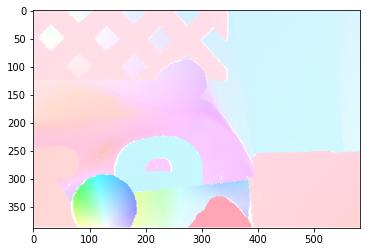

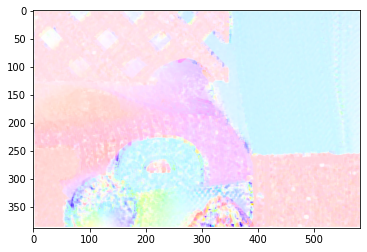

In [33]:
t = time.time()

u, v = lukas_kanade(image1, image2, window_size=5)

figure()
imshow(flow_image_gt, cmap='gray')

figure()
flow_image = flow_vis.flow_to_color(np.stack([u,v],axis=-1))
imshow(flow_image,cmap='gray')

print('Elaspsed time: ', time.time()-t)

## Part B: Lukas-Kanade with Pyramid

In previous part, the optical flow of each pixel is computed only based on a small neighbouring region. Therefore the algorithm cannot deal with large displacement. As a solution, we can apply the algorithm iteratively from coarse to fine.

We construct a image pyramid, apply the optical flow algorithm at each level starting from the coarsest resolution and propagate the computed flow to the next level. The propagation is done by first warping image1 with the estimated flow and then estimate the residual flow between the image2 and warped image1. You can use `ndimage.map_coordinates(image, [new_ys, new_xs])` for image warping.

*How to do typing*

*def hello(
    variablename1 : int, 
    variablename2 : double)*

**Complete the following lines for image warping and optical flow estimation & updating.**

max flow: 5.4253 flow range: u = -1.643 .. 5.425; v = -1.969 .. 2.206

max flow: 24.4788 flow range: u = -10.438 .. 10.696; v = -20.137 .. 24.470



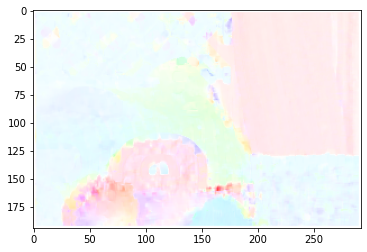

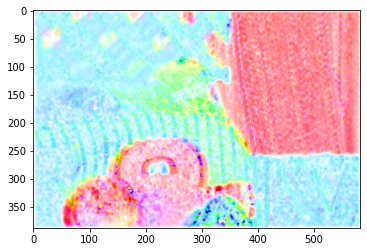

In [44]:
num_layers = 1
n_iter = 1
downscale = 2

# Construct image pyramids
pyramids1 = tf.pyramid_gaussian(image1, max_layer=num_layers, downscale=downscale, sigma=1, channel_axis=None)
pyramids2 = tf.pyramid_gaussian(image2, max_layer=num_layers, downscale=downscale, sigma=1, channel_axis=None)

u = np.zeros(image1.shape) # initialize the optical flow with 0
v = np.zeros(image1.shape)

for im1,im2 in zip(reversed(list(pyramids1)),reversed(list(pyramids2))):

    h,w = im1.shape

# we want to store the sol of the optical flow in u and v
# in each iteration, we'll change u and v by adding a small refinement in every iteration. 

# those 2 lines are only for resizing u and v to the current image size
    u = h/u.shape[0] * tf.resize(u, (h,w), order=1)
    v = h/u.shape[0] * tf.resize(v, (h,w), order=1)
    # 3 layers -> 3 levels of downscaling

    # Your codes here. Warp image.
   # u1, v1 = lukas_kanade(im1, im2, window_size=5
   # u1 , v1 = lukas_kanade(im1, im2, window_size=2)
   # im1_warp = ndimage.map_coordinates(im1, [v1, u1])
    #im1 = im1_warp

# MASTERSOL
    yy, xx = np.mgrid[:h, :w] # yy, xx the positions of the pixels in the image, initially
    # basically automatically, building a matrix and filling stuff...?
    # xx, yy gives pixels absolute position in the image
    rows, cols = yy + v, xx + u # y is the rows, rows & cols is giving you the pos of the pixels of 
    # where they're going to go in the next iteration
    im1_warp = ndimage.map_coordinates(im1, [rows, cols])
    # u is on the columns

    # update optical flow
    du, dv = lukas_kanade(im1_warp, im2, window_size = 5) # displacement

# actually, you need to put the reverse movement into this optical flow. To inverse the optical flow...?
# in theory, we should put the oposite of the optical flow
    # du, dv = lukas_kanade(im2, im1_warp, window_size = 5) 


    # should actually write minuses here!
    # u, v = u + du, v + dv # refine previous optical flow
    u, v = u - du, v - dv



#MINE
    # Your codes here. Update optical flow.
    # u,v =
    #u = u + u1
    #v = v + v1

     # Your codes here. Warp image.
   # u1, v1 = lukas_kanade(im1, im2, window_size=5
    # u1 , v1 = lukas_kanade(im1, im2, window_size=2)
    # im1_warp = ndimage.map_coordinates(im1, [v1, u1])

    # Your codes here. Update optical flow.
    # u,v =
    # u = u + u1
    # v = v + v1

    flow_image = flow_vis.flow_to_color(np.stack([u,v],axis=-1))
    figure()
    imshow(flow_image,cmap='gray')

## Part C: Frame Extrapolation with Optical Flow

Optical flow can be used for frame extrapolation. Given the two frames, we can predict the next few frames (assuming constant pixel motions). This can be done by scaling the optical flow and warping the image accordingly. 

**Complete the following lines for frame extrapolation.**

In [ ]:
h, w = image1.shape[:2]
yy, xx = np.mgrid[:h, :w]
flow = np.stack([-u, -v], axis=-1)


for i in range(1,10):
     
    # Your codes here. Extrapolate the next 10 frames, using the flow between img1 and img2 as one step.
    

    
    image1_warp = ndimage.map_coordinates()
    
    imshow(image1_warp,cmap='gray')
    
    IPython.display.clear_output(True)
    
    show()
    # optical flow is not able to guess what is behind the object, so you get those holes. 

# Part D: Exam question

![alt](Q1.png)
![alt](Q2.png)

![alt](Q3.png)

a) is the result of Horn-Schunk and the second one is Lukas-Kanade
You have smoothness in Horn-Schunk. In b) it's a sharp, a) is smooth. 